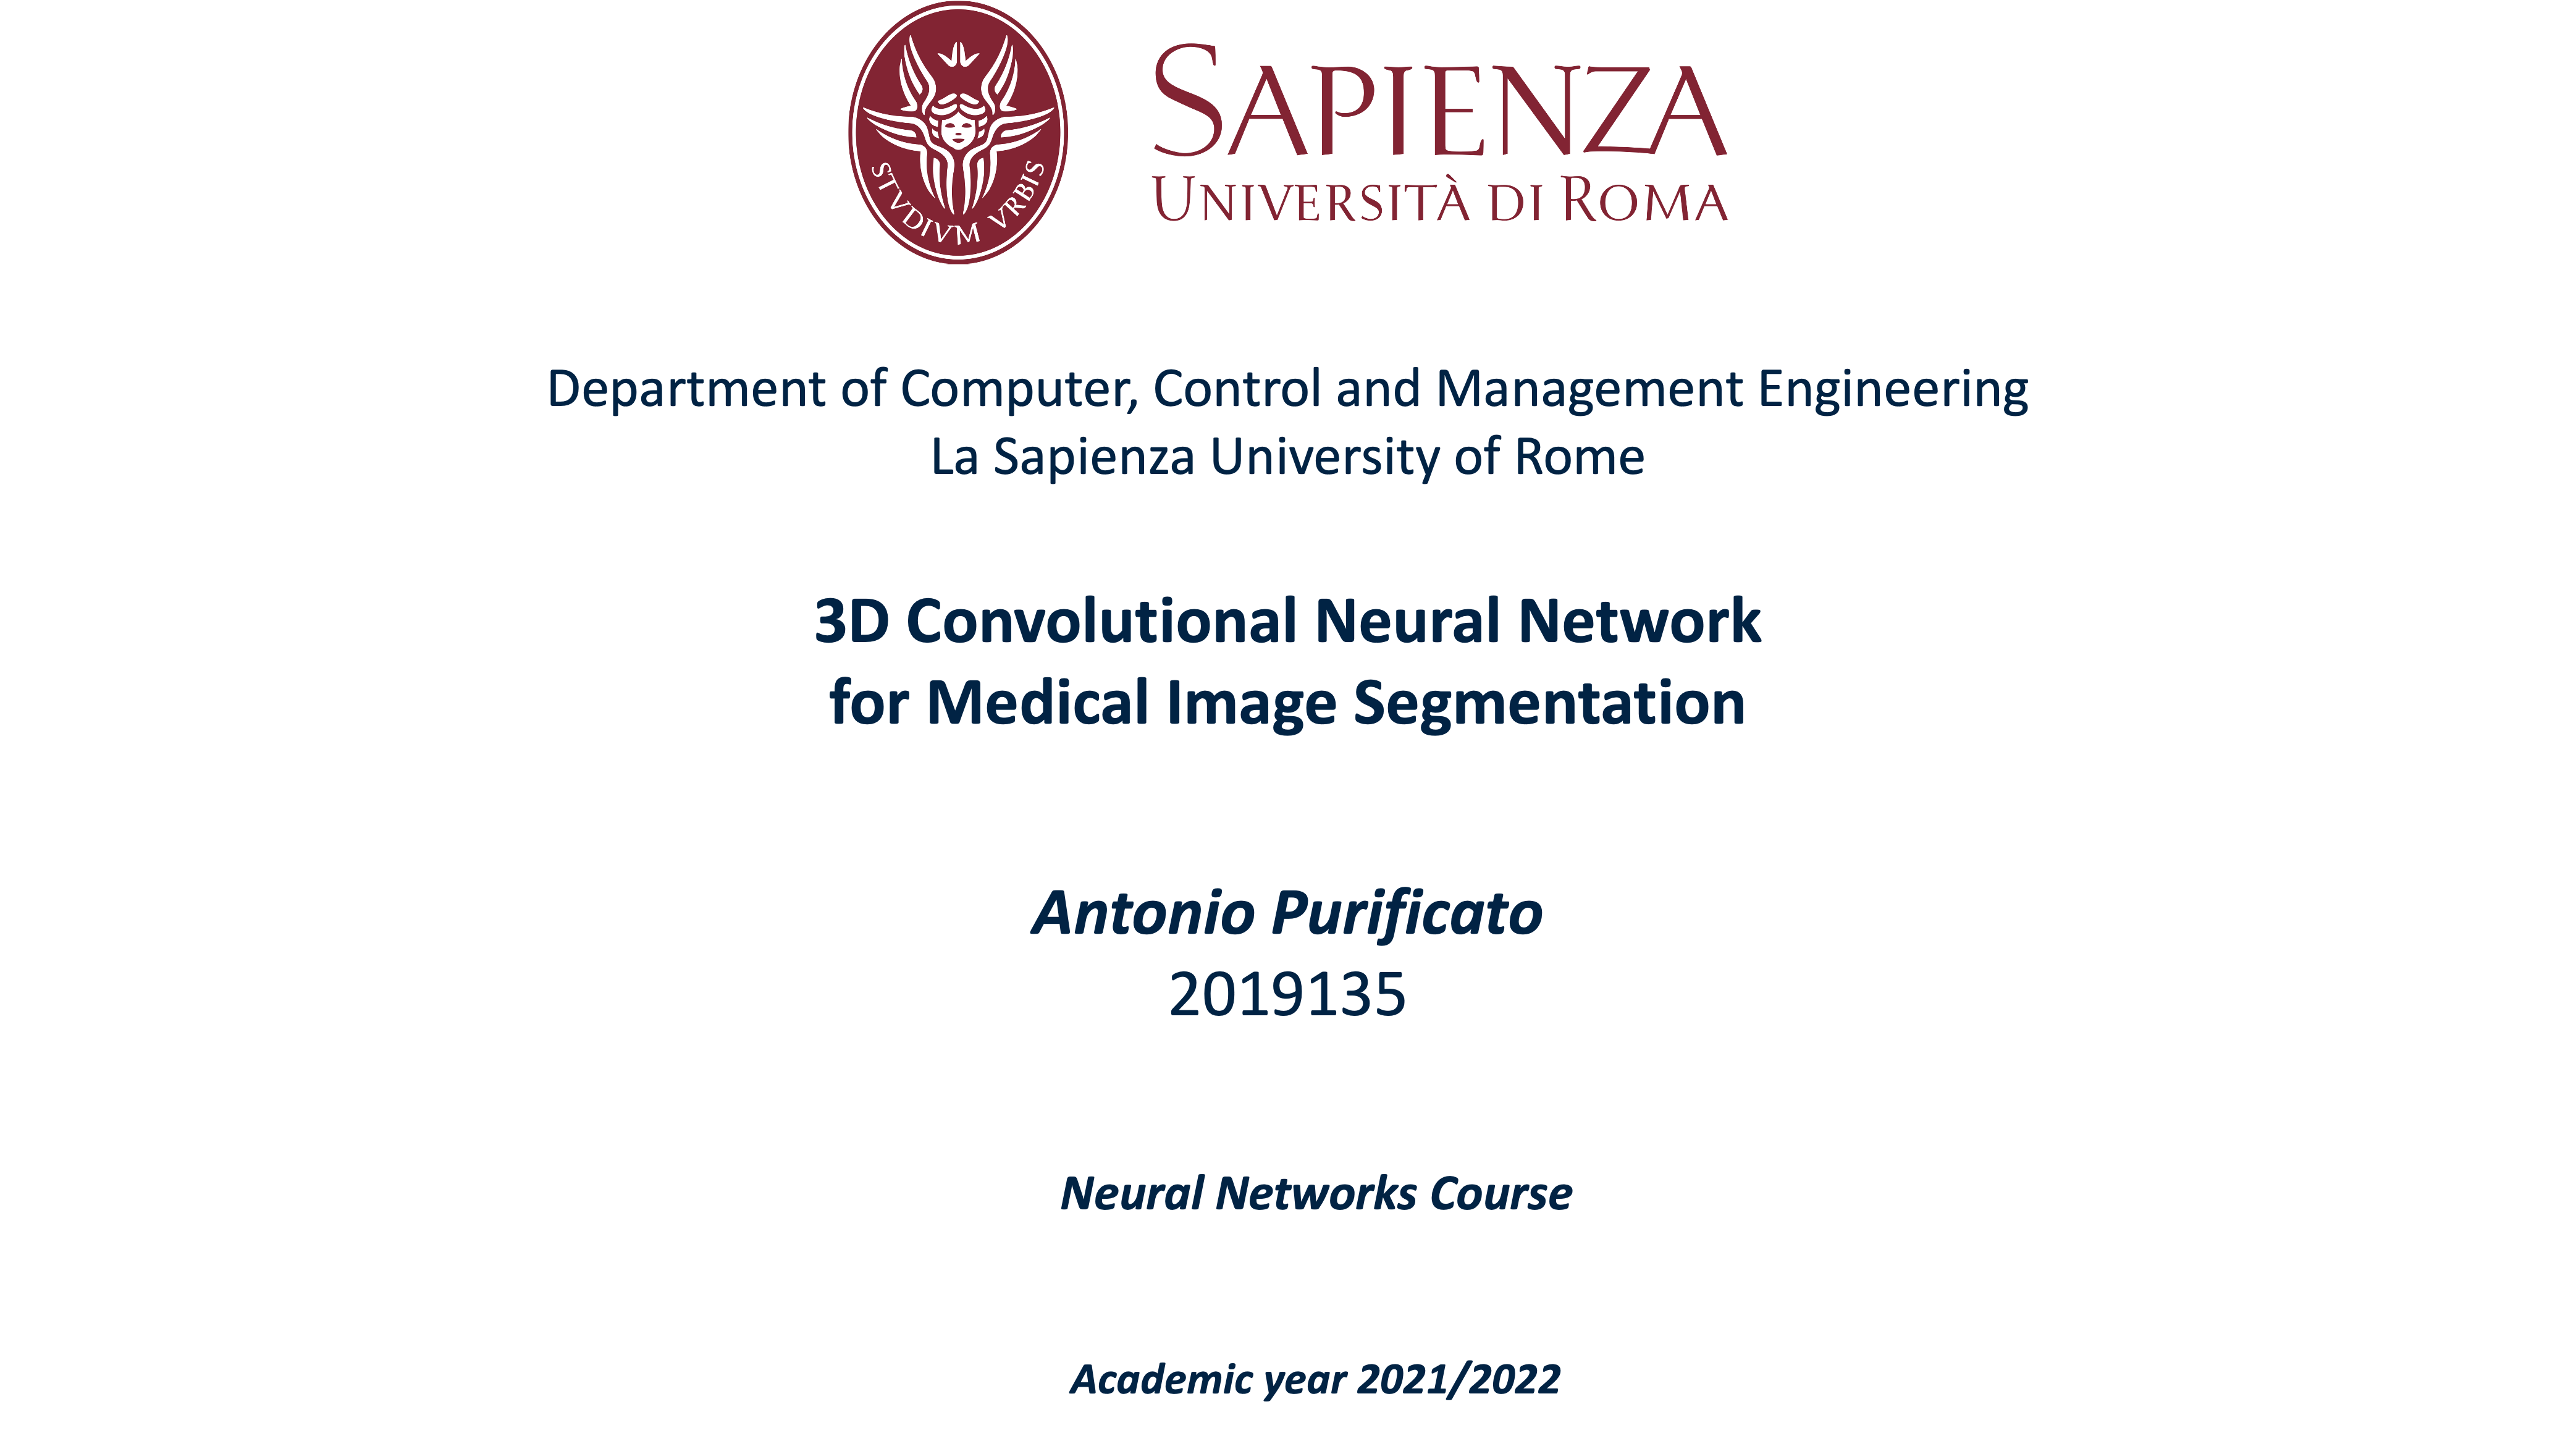

*The implementative choices of this architecture are described in the paper https://drive.google.com/file/d/1-E_rt2eUv7Uvdf-8gs7SZY4PtEN8nMQ6/view?usp=sharing*

<a href="https://colab.research.google.com/drive/1lMhDIFNGeG5gpeBYYEK0Ioer4o1eTiPn?authuser=1#scrollTo=0opSxAQeWeIn" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Setup

In [ ]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 2

# If the following value is False, the model will be downloaded and not computed
train_whole_images = True 

Install some PyPI packages:

In [ ]:
%%capture
!pip install matplotlib==3.1.3
%pip install --quiet --upgrade pip
%pip install --quiet torchio==0.18.57
!apt -qq install tree

Import modules:

In [ ]:
import enum
import time
import random
import multiprocessing
from pathlib import Path
from typing import Optional

import torch
import torch.nn as nn
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

## Data

The dataset used for this task IXI Tiny. The original IXI dataset is a collection of 600 MR brain images from normal, healthy subjects. Is available here: https://brain-development.org/ixi-dataset/.
This is a modification of the IXI dataset,  containing 566 
T1-weighted brain MR images and their corresponding brain segmentations.

### Dataset

In [ ]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=0'
dataset_path = 'ixi_tiny.zip'
dataset_dir_name = 'ixi_tiny'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [ ]:
%%capture
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}


SubjectDataset is one of the most important classes in the library. It receives as input a list of `torchio.Subject` instances and an optional `torchio.transforms.Transform`.

The inputs to the subject class are instances of `torchio.Image`. The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

In [ ]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


Example of one of the subjects in the dataset.

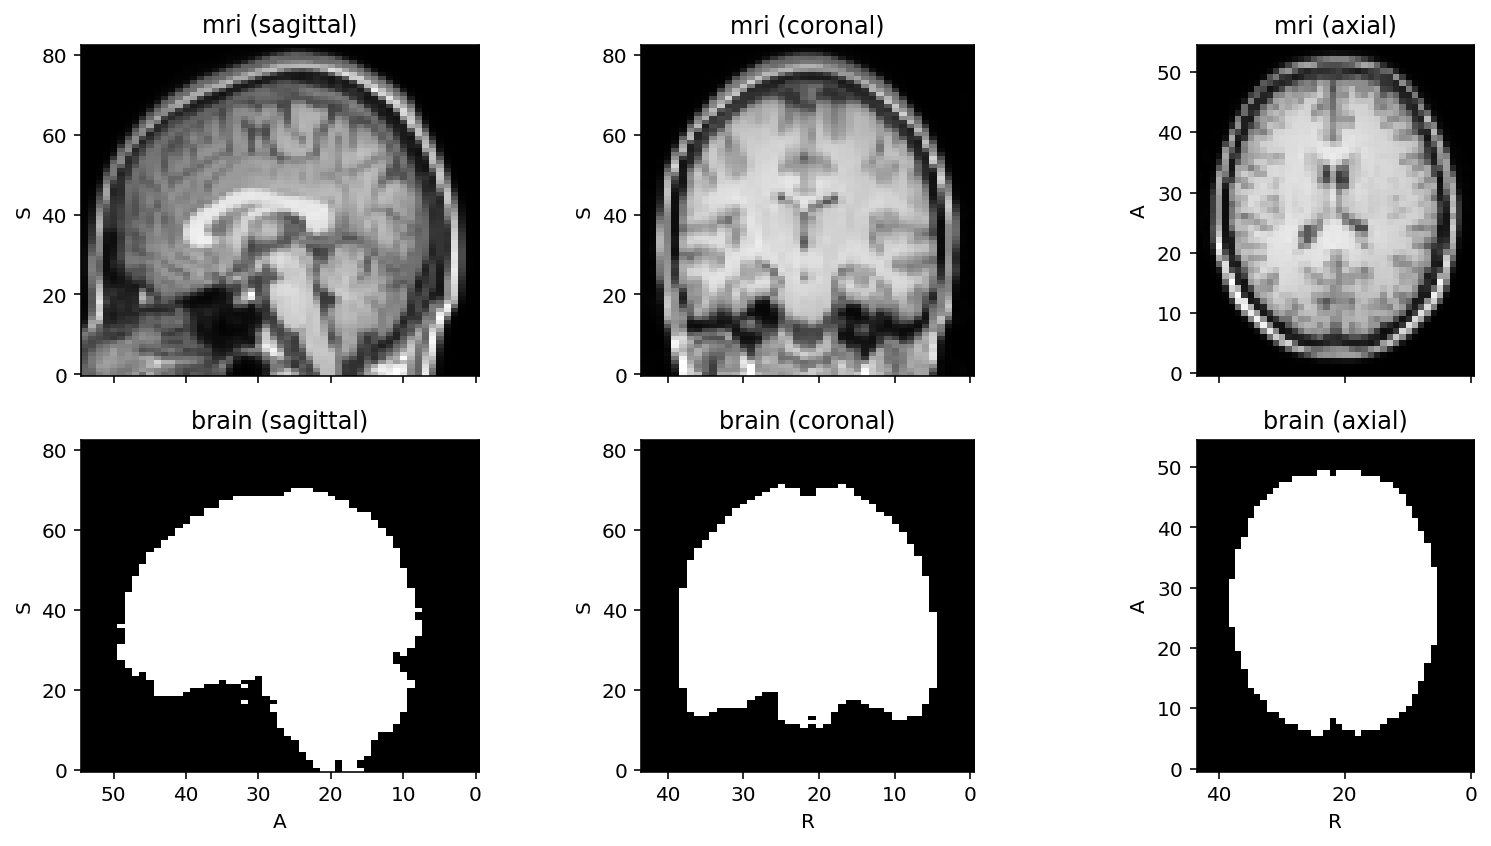

In [ ]:
one_subject = dataset[0]
one_subject.plot()

#### Normalization

We will use the HistogramStandardization and the ZNormalization transforms to normalize our images intensity.

In [ ]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)

100%|██████████| 566/566 [00:07<00:00, 75.49it/s]


Z-standardization or normalization means that our output data will have zero mean and unit variance.

In [ ]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

## Training a network



The transform is generated using data augmentation and two standardization techniques.

In [ ]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 57 subjects


#U-Net Model

##Basic convolutional block

In [ ]:
#Main class of a generic CNN. In the constructor we set some parameters for our block.
class ConvolutionalBlock(nn.Module):
    def __init__(
            self,
            dimensions: int,
            in_channels: int,
            out_channels: int,
            normalization: Optional[str] = None,
            kernel_size: int = 3,
            activation: Optional[str] = 'ReLU',
            preactivation: bool = False,
            padding: int = 0,
            padding_mode: str = 'zeros',
            dilation: Optional[int] = None,
            dropout: float = 0,
            ):
        super().__init__()

        block = nn.ModuleList()

        dilation = 1 if dilation is None else dilation
        if padding:
            total_padding = kernel_size + 2 * (dilation - 1) - 1
            padding = total_padding // 2

        class_name = 'Conv{}d'.format(dimensions)
        conv_class = getattr(nn, class_name)
        no_bias = not preactivation and (normalization is not None)
        conv_layer = conv_class(
            in_channels,
            out_channels,
            kernel_size,
            padding=padding,
            padding_mode=padding_mode,
            dilation=dilation,
            bias=not no_bias,
        )

        #We have also the possibility to use different types of normalization
        norm_layer = None
        if normalization is not None:
            class_name = '{}Norm{}d'.format(
                normalization.capitalize(), dimensions)
            norm_class = getattr(nn, class_name)
            num_features = in_channels if preactivation else out_channels
            norm_layer = norm_class(num_features)

        activation_layer = None
        if activation is not None:
            activation_layer = getattr(nn, activation)()

        if preactivation:
            self.add_if_not_none(block, norm_layer)
            self.add_if_not_none(block, activation_layer)
            self.add_if_not_none(block, conv_layer)
        else:
            self.add_if_not_none(block, conv_layer)
            self.add_if_not_none(block, norm_layer)
            self.add_if_not_none(block, activation_layer)

        dropout_layer = None
        if dropout:
            class_name = 'Dropout{}d'.format(dimensions)
            dropout_class = getattr(nn, class_name)
            dropout_layer = dropout_class(p=dropout)
            self.add_if_not_none(block, dropout_layer)

        #These 3 lines of code are what in the paper is described as:
        #Convolutional layer + Normalization + ReLu activation function
        self.conv_layer = conv_layer
        self.norm_layer = norm_layer
        self.activation_layer = activation_layer
        self.dropout_layer = dropout_layer

        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)

    @staticmethod
    def add_if_not_none(module_list, module):
        if module is not None:
            module_list.append(module)

##Encoder

When we we have a transform-based architecture we have always an encoder and a decoder. The encoder generates samples from a probability distribution $\mathit{p(X)}$ and the decoder tries to understand is a generic sample is derived from the probability distribution $\mathit{p(X)}$ or not.

In [ ]:
class Encoder(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels_first: int,
            dimensions: int,
            pooling_type: str,
            num_encoding_blocks: int,
            normalization: Optional[str],
            preactivation: bool = False,
            residual: bool = False,
            padding: int = 0,
            padding_mode: str = 'zeros',
            activation: Optional[str] = 'ReLU',
            initial_dilation: Optional[int] = None,
            dropout: float = 0,
            ):
        super().__init__()

        self.encoding_blocks = nn.ModuleList()
        self.dilation = initial_dilation
        is_first_block = True
        for _ in range(num_encoding_blocks):
            encoding_block = EncodingBlock(
                in_channels,
                out_channels_first,
                dimensions,
                normalization,
                pooling_type,
                preactivation,
                is_first_block=is_first_block,
                residual=residual,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                dilation=self.dilation,
                dropout=dropout,
            )
            is_first_block = False
            self.encoding_blocks.append(encoding_block)
            if dimensions == 2:
                in_channels = out_channels_first
                out_channels_first = in_channels * 2
            elif dimensions == 3:
                in_channels = 2 * out_channels_first
                out_channels_first = in_channels
            if self.dilation is not None:
                self.dilation *= 2

    def forward(self, x):
        skip_connections = []
        for encoding_block in self.encoding_blocks:
            x, skip_connnection = encoding_block(x)
            skip_connections.append(skip_connnection)
        return skip_connections, x

    @property
    def out_channels(self):
        return self.encoding_blocks[-1].out_channels


class EncodingBlock(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels_first: int,
            dimensions: int,
            normalization: Optional[str],
            pooling_type: Optional[str],
            preactivation: bool = False,
            is_first_block: bool = False,
            residual: bool = False,
            padding: int = 0,
            padding_mode: str = 'zeros',
            activation: Optional[str] = 'ReLU',
            dilation: Optional[int] = None,
            dropout: float = 0,
            ):
        super().__init__()

        self.preactivation = preactivation
        self.normalization = normalization

        self.residual = residual

        if is_first_block:
            normalization = None
            preactivation = None
        else:
            normalization = self.normalization
            preactivation = self.preactivation

        self.conv1 = ConvolutionalBlock(
            dimensions,
            in_channels,
            out_channels_first,
            normalization=normalization,
            preactivation=preactivation,
            padding=padding,
            padding_mode=padding_mode,
            activation=activation,
            dilation=dilation,
            dropout=dropout,
        )

        if dimensions == 2:
            out_channels_second = out_channels_first
        elif dimensions == 3:
            out_channels_second = 2 * out_channels_first
        self.conv2 = ConvolutionalBlock(
            dimensions,
            out_channels_first,
            out_channels_second,
            normalization=self.normalization,
            preactivation=self.preactivation,
            padding=padding,
            activation=activation,
            dilation=dilation,
            dropout=dropout,
        )

        if residual:
            self.conv_residual = ConvolutionalBlock(
                dimensions,
                in_channels,
                out_channels_second,
                kernel_size=1,
                normalization=None,
                activation=None,
            )

        self.downsample = None
        if pooling_type is not None:
            self.downsample = get_downsampling_layer(dimensions, pooling_type)

    def forward(self, x):
        if self.residual:
            connection = self.conv_residual(x)
            x = self.conv1(x)
            x = self.conv2(x)
            x += connection
        else:
            x = self.conv1(x)
            x = self.conv2(x)
        if self.downsample is None:
            return x
        else:
            skip_connection = x
            x = self.downsample(x)
            return x, skip_connection

    @property
    def out_channels(self):
        return self.conv2.conv_layer.out_channels

#This method try to implement my attention mechanism. For each layer of the network
#is permorfmed downsampling and in the decoder we can upsample using 5 different modalities


def get_downsampling_layer(
        dimensions: int,
        pooling_type: str,
        kernel_size: int = 2,
        ) -> nn.Module:
    class_name = '{}Pool{}d'.format(pooling_type.capitalize(), dimensions)
    class_ = getattr(nn, class_name)
    return class_(kernel_size)

##Decoder

In [ ]:
CHANNELS_DIMENSION = 1
UPSAMPLING_MODES = (
    'nearest',
    'linear',
    'bilinear',
    'bicubic',
    'trilinear',
)


class Decoder(nn.Module):
    def __init__(
            self,
            in_channels_skip_connection: int,
            dimensions: int,
            upsampling_type: str,
            num_decoding_blocks: int,
            normalization: Optional[str],
            preactivation: bool = False,
            residual: bool = False,
            padding: int = 0,
            padding_mode: str = 'zeros',
            activation: Optional[str] = 'ReLU',
            initial_dilation: Optional[int] = None,
            dropout: float = 0,
            ):
        super().__init__()
        
        
        upsampling_type = fix_upsampling_type(upsampling_type, dimensions)
        self.decoding_blocks = nn.ModuleList()
        self.dilation = initial_dilation
        for _ in range(num_decoding_blocks):
            decoding_block = DecodingBlock(
                in_channels_skip_connection,
                dimensions,
                upsampling_type,
                normalization=normalization,
                preactivation=preactivation,
                residual=residual,
                padding=padding,
                padding_mode=padding_mode,
                activation=activation,
                dilation=self.dilation,
                dropout=dropout,
            )
            self.decoding_blocks.append(decoding_block)
            in_channels_skip_connection //= 2
            if self.dilation is not None:
                self.dilation //= 2

    def forward(self, skip_connections, x):
        zipped = zip(reversed(skip_connections), self.decoding_blocks)
        for skip_connection, decoding_block in zipped:
            x = decoding_block(skip_connection, x)
        return x

#Is possible to select between different types of upsampling, but we usually use the standard type (linear)
class DecodingBlock(nn.Module):
    def __init__(
            self,
            in_channels_skip_connection: int,
            dimensions: int,
            upsampling_type: str,
            normalization: Optional[str],
            preactivation: bool = True,
            residual: bool = False,
            padding: int = 0,
            padding_mode: str = 'zeros',
            activation: Optional[str] = 'ReLU',
            dilation: Optional[int] = None,
            dropout: float = 0,
            ):
        super().__init__()

        self.residual = residual

        if upsampling_type == 'conv':
            in_channels = out_channels = 2 * in_channels_skip_connection
            self.upsample = get_conv_transpose_layer(
                dimensions, in_channels, out_channels)
        else:
            self.upsample = get_upsampling_layer(upsampling_type)
        in_channels_first = in_channels_skip_connection * (1 + 2)
        out_channels = in_channels_skip_connection
        self.conv1 = ConvolutionalBlock(
            dimensions,
            in_channels_first,
            out_channels,
            normalization=normalization,
            preactivation=preactivation,
            padding=padding,
            padding_mode=padding_mode,
            activation=activation,
            dilation=dilation,
            dropout=dropout,
        )
        in_channels_second = out_channels
        self.conv2 = ConvolutionalBlock(
            dimensions,
            in_channels_second,
            out_channels,
            normalization=normalization,
            preactivation=preactivation,
            padding=padding,
            padding_mode=padding_mode,
            activation=activation,
            dilation=dilation,
            dropout=dropout,
        )

        if residual:
            self.conv_residual = ConvolutionalBlock(
                dimensions,
                in_channels_first,
                out_channels,
                kernel_size=1,
                normalization=None,
                activation=None,
            )

    def forward(self, skip_connection, x):
        x = self.upsample(x)
        skip_connection = self.center_crop(skip_connection, x)
        x = torch.cat((skip_connection, x), dim=CHANNELS_DIMENSION)
        if self.residual:
            connection = self.conv_residual(x)
            x = self.conv1(x)
            x = self.conv2(x)
            x += connection
        else:
            x = self.conv1(x)
            x = self.conv2(x)
        return x

    def center_crop(self, skip_connection, x):
        skip_shape = torch.tensor(skip_connection.shape)
        x_shape = torch.tensor(x.shape)
        crop = skip_shape[2:] - x_shape[2:]
        half_crop = crop // 2
        # If skip_connection is 10, 20, 30 and x is (6, 14, 12)
        # Then pad will be (-2, -2, -3, -3, -9, -9)
        pad = -torch.stack((half_crop, half_crop)).t().flatten()
        skip_connection = F.pad(skip_connection, pad.tolist())
        return skip_connection


def get_upsampling_layer(upsampling_type: str) -> nn.Upsample:
    if upsampling_type not in UPSAMPLING_MODES:
        message = (
            'Upsampling type is "{}"'
            ' but should be one of the following: {}'
        )
        message = message.format(upsampling_type, UPSAMPLING_MODES)
        raise ValueError(message)
    upsample = nn.Upsample(
        scale_factor=2,
        mode=upsampling_type,
        align_corners=False,
    )
    return upsample


def get_conv_transpose_layer(dimensions, in_channels, out_channels):
    class_name = 'ConvTranspose{}d'.format(dimensions)
    conv_class = getattr(nn, class_name)
    conv_layer = conv_class(in_channels, out_channels, kernel_size=2, stride=2)
    return conv_layer


def fix_upsampling_type(upsampling_type: str, dimensions: int):
    if upsampling_type == 'linear':
        if dimensions == 2:
            upsampling_type = 'bilinear'
        elif dimensions == 3:
            upsampling_type = 'trilinear'
    return upsampling_type

##U-Net main module

In [ ]:
__all__ = ['UNet', 'UNet2D', 'UNet3D']

class UNet(nn.Module):
    def __init__(
            self,
            in_channels: int = 1,
            out_classes: int = 2,
            dimensions: int = 2,
            num_encoding_blocks: int = 5,
            out_channels_first_layer: int = 64,
            normalization: Optional[str] = None,
            pooling_type: str = 'max',
            upsampling_type: str = 'conv',
            preactivation: bool = False,
            residual: bool = False,
            padding: int = 0,
            padding_mode: str = 'zeros',
            activation: Optional[str] = 'ReLU',
            initial_dilation: Optional[int] = None,
            dropout: float = 0,
            monte_carlo_dropout: float = 0,
            ):
        super().__init__()
        depth = num_encoding_blocks - 1

        # Force padding if residual blocks
        if residual:
            padding = 1

        # Encoder
        self.encoder = Encoder(
            in_channels,
            out_channels_first_layer,
            dimensions,
            pooling_type,
            depth,
            normalization,
            preactivation=preactivation,
            residual=residual,
            padding=padding,
            padding_mode=padding_mode,
            activation=activation,
            initial_dilation=initial_dilation,
            dropout=dropout,
        )

        # Bottom (last encoding block)
        in_channels = self.encoder.out_channels
        if dimensions == 2:
            out_channels_first = 2 * in_channels
        else:
            out_channels_first = in_channels

        self.bottom_block = EncodingBlock(
            in_channels,
            out_channels_first,
            dimensions,
            normalization,
            pooling_type=None,
            preactivation=preactivation,
            residual=residual,
            padding=padding,
            padding_mode=padding_mode,
            activation=activation,
            dilation=self.encoder.dilation,
            dropout=dropout,
        )

        # Decoder
        if dimensions == 2:
            power = depth - 1
        elif dimensions == 3:
            power = depth
        in_channels = self.bottom_block.out_channels
        in_channels_skip_connection = out_channels_first_layer * 2**power
        num_decoding_blocks = depth
        self.decoder = Decoder(
            in_channels_skip_connection,
            dimensions,
            upsampling_type,
            num_decoding_blocks,
            normalization=normalization,
            preactivation=preactivation,
            residual=residual,
            padding=padding,
            padding_mode=padding_mode,
            activation=activation,
            initial_dilation=self.encoder.dilation,
            dropout=dropout,
        )

        # Monte Carlo dropout
        self.monte_carlo_layer = None
        if monte_carlo_dropout:
            dropout_class = getattr(nn, 'Dropout{}d'.format(dimensions))
            self.monte_carlo_layer = dropout_class(p=monte_carlo_dropout)

        # Classifier
        if dimensions == 2:
            in_channels = out_channels_first_layer
        elif dimensions == 3:
            in_channels = 2 * out_channels_first_layer
        self.classifier = ConvolutionalBlock(
            dimensions, in_channels, out_classes,
            kernel_size=1, activation=None,
        )

    def forward(self, x):
        skip_connections, encoding = self.encoder(x)
        encoding = self.bottom_block(encoding)
        x = self.decoder(skip_connections, encoding)
        if self.monte_carlo_layer is not None:
            x = self.monte_carlo_layer(x)
        return self.classifier(x)

#The difference between 2D and 3D U-Net is not only in the dimension of our input, but also in the output channels
class UNet2D(UNet):
    def __init__(self, *args, **user_kwargs):
        kwargs = {}
        kwargs['dimensions'] = 2
        kwargs['num_encoding_blocks'] = 5
        kwargs['out_channels_first_layer'] = 64
        kwargs.update(user_kwargs)
        super().__init__(*args, **kwargs)


class UNet3D(UNet):
    def __init__(self, *args, **user_kwargs):
        kwargs = {}
        kwargs['dimensions'] = 3
        kwargs['num_encoding_blocks'] = 4
        kwargs['out_channels_first_layer'] = 32
        kwargs['normalization'] = 'batch'
        kwargs.update(user_kwargs)
        super().__init__(*args, **kwargs)

#Loss function

We define the loss function. For this task is used the Dice loss. We also select the model and the optimizer.
Is possible to use the 2D model simply modifying `UNet3D` with `UNet2D` in the method `get_model_and_optimizer`.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    targets = batch['brain'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

#DataLoader creation

The selected batch size is 16 for the training DataLoader and 32 for the validation DataLoader.

In [ ]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

#Train

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Validation mean loss: 0.536
Starting epoch 1


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.285


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.226
Starting epoch 2


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.186


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.159


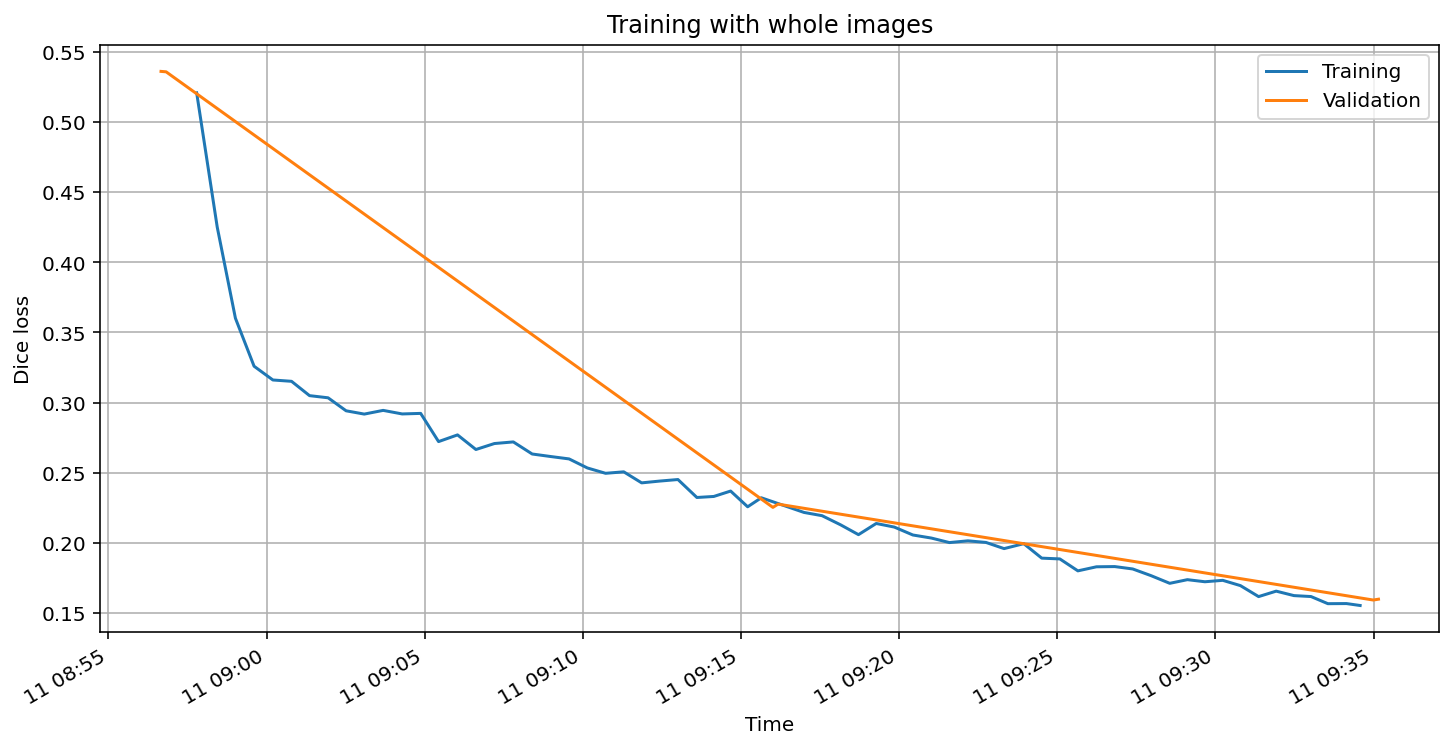

In [ ]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

# Test

The Dice loss is used as performance metric. The dice loss is simply equal to: $\mathit{1- DiceScore}$.
The $\mathit{DiceScore}$ is the most common metric in image segmentation.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


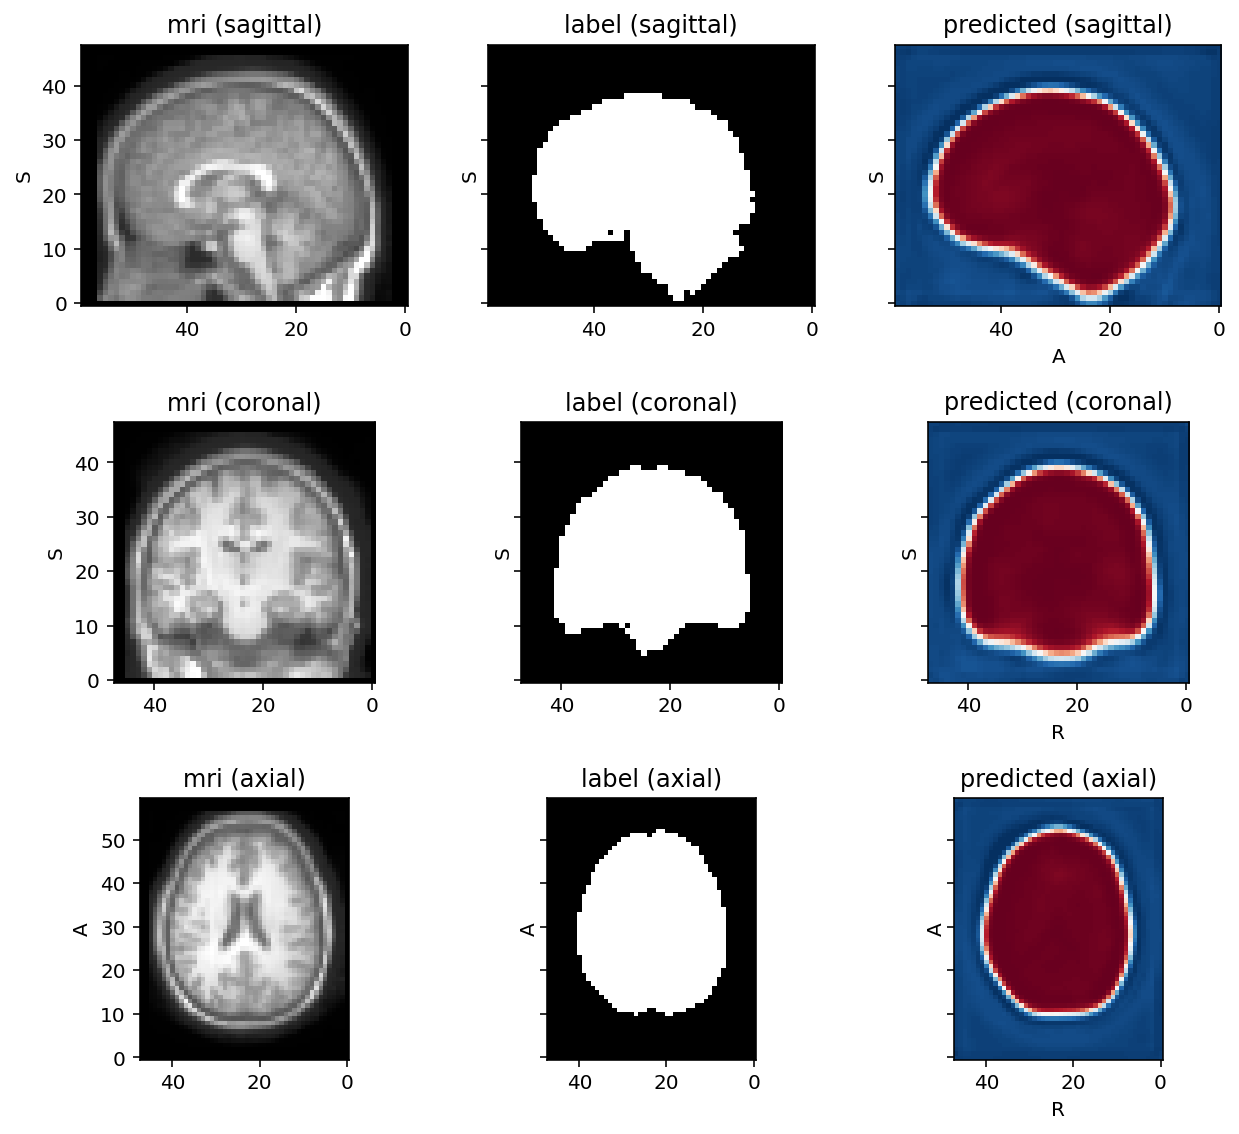

In [ ]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['brain'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})